/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:234: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['a', 'b', 'c', 'd'])
/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['e', 'f', 'g', 'h'])


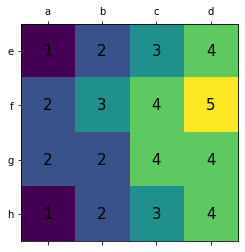

/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:252: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['insert', 'fairness', 'notions', 'here'])
/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:253: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No Missing', 'MCAR', 'MAR', 'NMAR'])


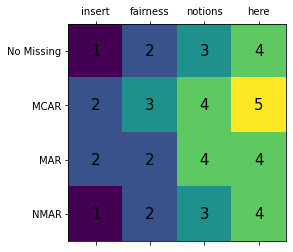

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [1]:
import pandas as pd
import os
import sys
from src.cleaning import datacleaning
from src import data_generation
from src.preparation import model_perform
import pandas as pd
import numpy as np
import aif360
from sklearn.model_selection import train_test_split
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference

In [2]:
data = datacleaning.cleaning(os.path.join(os.path.dirname(
    os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [3]:
target = sys.argv[1]

if target == "test":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/test.csv'))

if target == "all":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [4]:
data.isna().sum()

complaint_id                0
complainant_ethnicity       0
complainant_age_incident    0
allegation                  0
contact_reason              0
substantiated               0
dtype: int64

In [5]:
data.head()

,complaint_id,complainant_ethnicity,complainant_age_incident,allegation,contact_reason,substantiated
0,42835,Black,38.0,Failure to provide RTKA card,Report-domestic dispute,True
1,24601,Black,26.0,Action,Moving violation,True
2,24601,Black,26.0,Race,Moving violation,True
3,26146,Black,45.0,Question,PD suspected C/V of violation/crime - street,True
5,37256,White,31.0,Refusal to process civilian complaint,C/V telephoned PCT,True


In [6]:
train, test = train_test_split(data, train_size=0.8)

## Missingness Creation

We want the attribute with missingness to have around the same proportion of missingness for each type. This is because we don't want the amount of missingness to be a confounding factor in our results.

In [7]:
t = train.copy()
mcar = data_generation.mcar(t, 'substantiated')

/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [8]:
mcar['substantiated'].isna().sum() / mcar.shape[0]

0.20454960716243376

In [9]:
mcar = mcar.dropna(subset = 'substantiated')

In [10]:
t = train.copy()
mar = data_generation.mar(t, 'substantiated', 'complainant_ethnicity', 0.3)

/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[miss_column].iloc[i] = np.nan


In [11]:
mar['substantiated'].isna().sum() / mar.shape[0]

0.16937694134843778

In [12]:
mar = mar.dropna(subset = 'substantiated')

In [13]:
t = train.copy()
nmar = data_generation.nmar(t, 'substantiated', 0.3)

/home/gykim/MissingnessFairnessAnalysis/src/data_generation.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [14]:
nmar['substantiated'].isna().sum() / nmar.shape[0]

0.18472501370363603

In [15]:
nmar = nmar.dropna(subset = 'substantiated')

Now we will "handle" the missingness by dropping missing values.

## Applying Fairness Notions


In [16]:
cat = ["complainant_ethnicity", "complainant_age_incident", "allegation", "contact_reason"]

In [17]:
acc = []

### Calculating fairnes notions for No Missingness At All

In [18]:
#storing fairness notions for no missingness
no_missing_fairness = []
no_missing = model_perform.model(train, test, cat)
no_missing_fairness.append(no_missing)


/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/gykim/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  war

accuracy: 0.6526585053900968
atatistical parity: 0.40478801169590645
equality of odds: 0.4762856450719823
equality of opportunity: 0.6168154761904762


/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
no_missing

[0.6526585053900968,
 0.40478801169590645,
 0.4762856450719823,
 0.6168154761904762]

### Fairness notions for NMAR

In [20]:
train_nmar, test_nmar = train_test_split(nmar, test_size=0.2)

In [21]:
nmar_fairness = []
nmar_model = model_perform.model_missing(train_nmar, test_nmar, cat)
nmar_fairness.append(nmar_model)

/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy: 0.7747899159663866
statistical parity: 0.041468198374894925
equality of odds: 0.06559546067220312
equality of opportunity: 0.11137440758293839


/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MCAR

In [22]:
train_mcar, test_mcar = train_test_split(mcar, test_size=0.2)


In [23]:
mcar_fairness = []
mcar_model = model_perform.model_missing(train_mcar, test_mcar, cat)
mcar_fairness.append(mcar_model)

/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy: 0.7631352282515074
statistical parity: 0.04738655944859276
equality of odds: 0.07354857025418088
equality of opportunity: 0.12669683257918551


/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MAR

In [24]:
train_mar, test_mar = train_test_split(mar, test_size=0.2)


In [25]:
mar_fairness = []
mar_model = model_perform.model_missing(train_mar, test_mar, cat)
mar_fairness.append(mar_model)

/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


accuracy: 0.765740995325818
statistical parity: 0.0407040704070407
equality of odds: 0.06383927774903203
equality of opportunity: 0.10975609756097561


/home/gykim/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gykim/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#put our fairness statistics into arrays for future usage
acc = [no_missing_fairness[0][0],nmar_fairness[0][0],mcar_fairness[0][0],mar_fairness[0][0]]
par= [no_missing_fairness[0][1],nmar_fairness[0][1],mcar_fairness[0][1],mar_fairness[0][1]]
odds= [no_missing_fairness[0][2],nmar_fairness[0][2],mcar_fairness[0][2],mar_fairness[0][2]]
opp = [no_missing_fairness[0][3],nmar_fairness[0][3],mcar_fairness[0][3],mar_fairness[0][3]]

## Visualizing Our Results

In [27]:
import matplotlib.pyplot as plt

In [28]:
labels = ['No Missingess,', 'NMAR', 'MCAR', 'MAR']

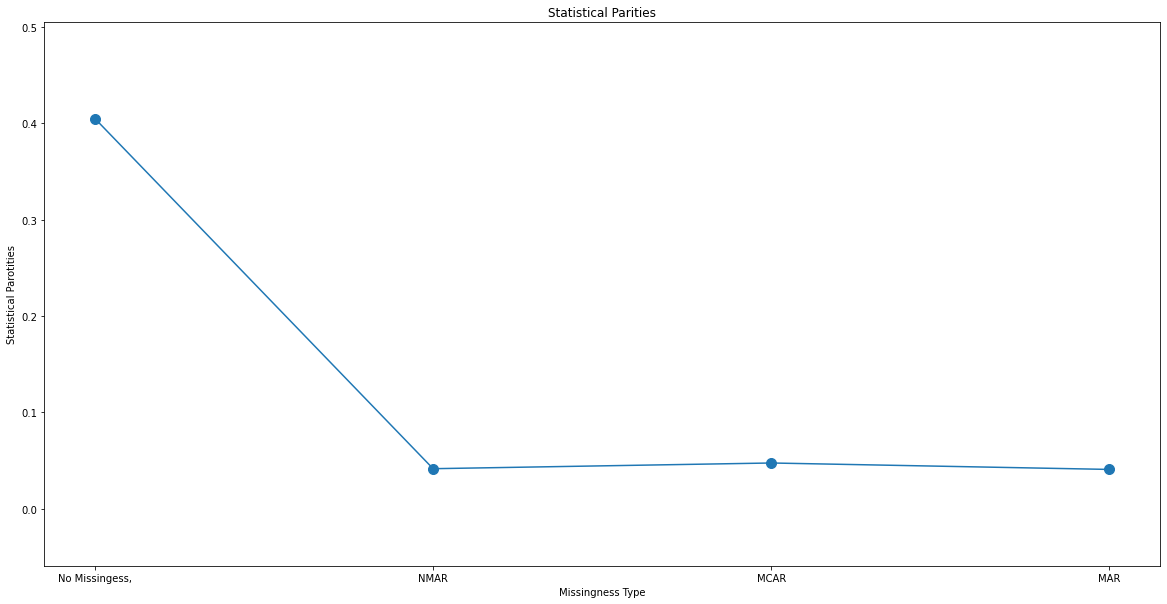

In [29]:
plt.figure(figsize = (20, 10))
plt.title('Statistical Parities')
plt.xlabel('Missingness Type')
plt.ylabel('Statistical Parotities')
plt.ylim(min(par) - 0.1, max(par) + 0.1)
plt.plot(labels, par, marker='.', markersize = 20)

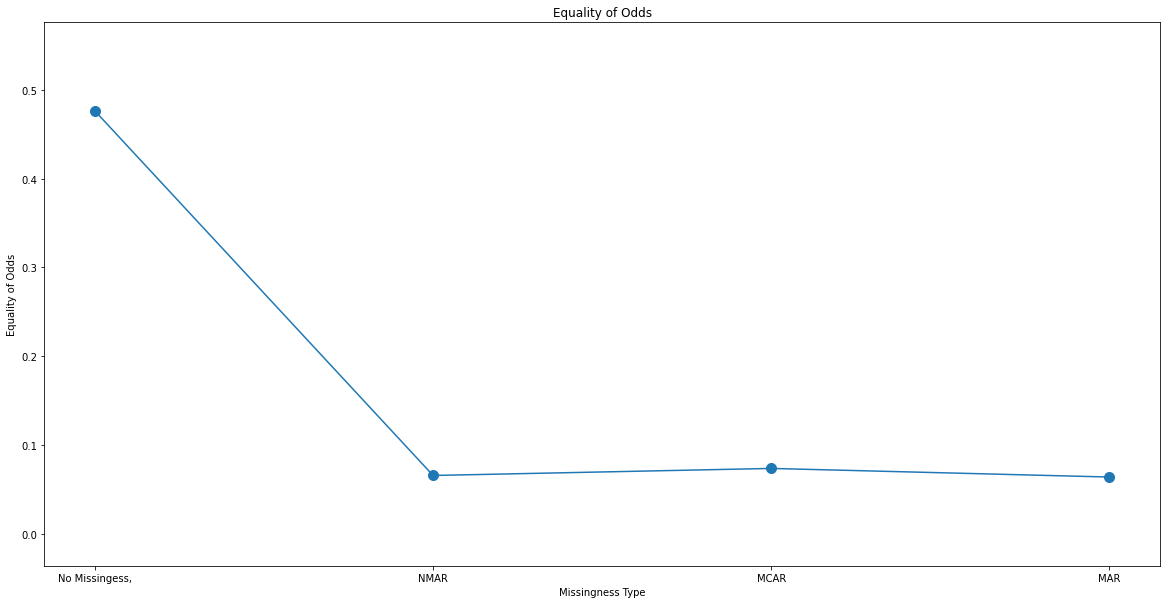

In [30]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Odds')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Odds')
plt.ylim(min(odds)-0.1,max(odds) + 0.1)
plt.plot(labels, odds, marker='.', markersize = 20)

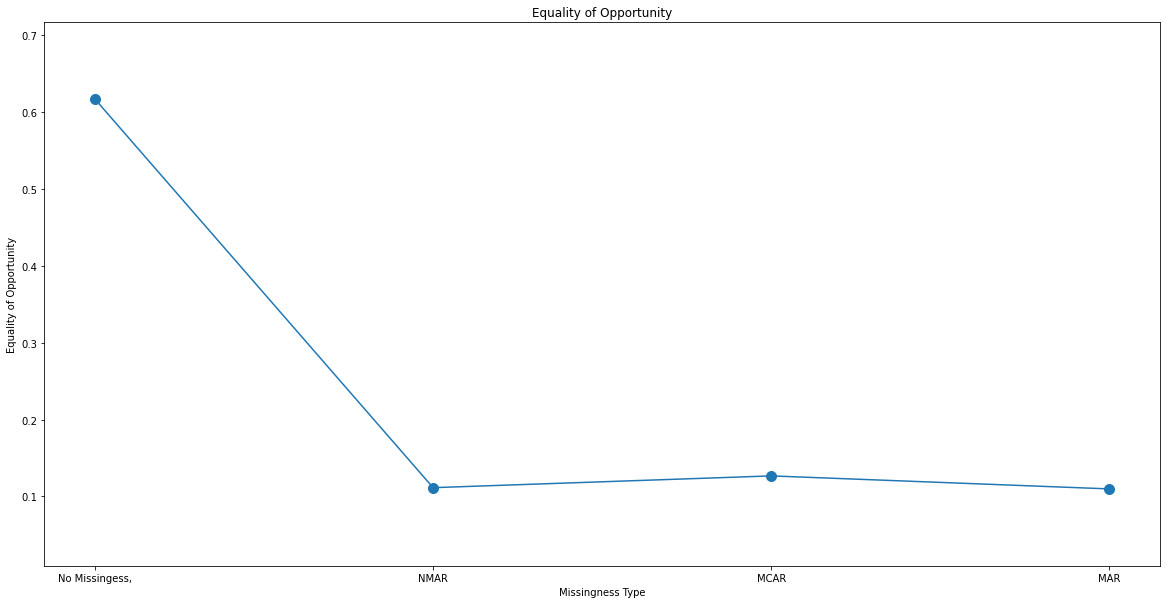

In [31]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Opportunity')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Opportunity')
plt.ylim(min(opp)-0.1,max(opp) + 0.1)
plt.plot(labels, opp, marker='.', markersize = 20)

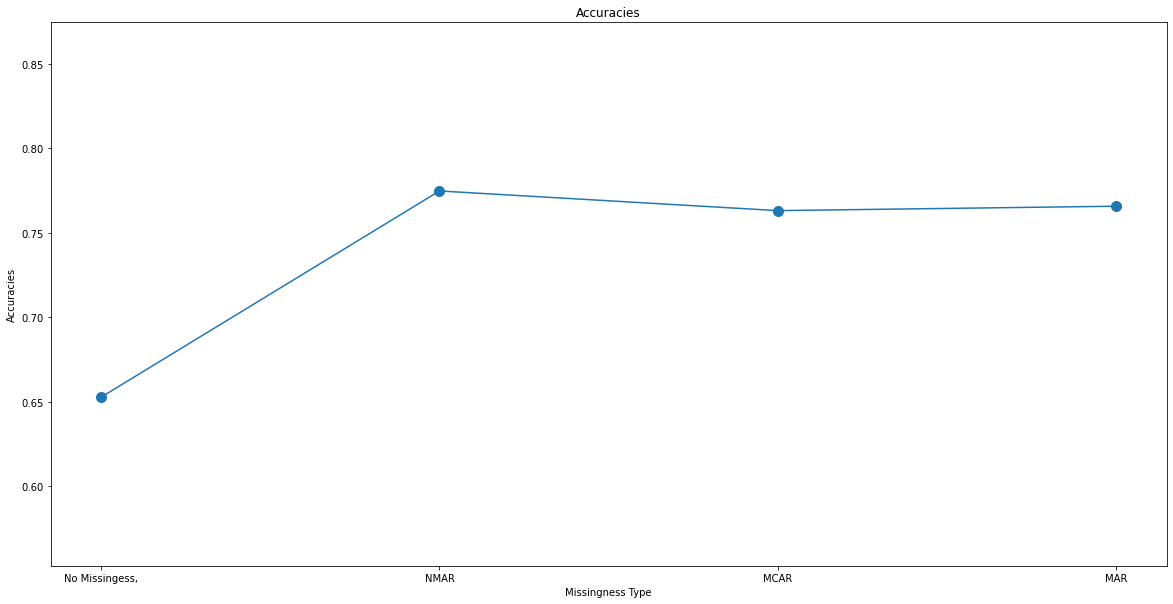

In [33]:
plt.figure(figsize = (20, 10))
plt.title('Accuracies')
plt.xlabel('Missingness Type')
plt.ylabel('Accuracies')
plt.ylim(min(acc)-0.1,max(acc) + 0.1)
plt.plot(labels, acc, marker='.', markersize = 20)